## Introduction: Business Problem 

This project deals with discussing the neighborhoods of Delhi, the capital of India. This project would specifically help Business people planning to start Restaurants, Hotels, etc. in Delhi, India

The Foursquare API is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. The optimal number of clusters can be obtained using silhouette score. Folium visualization library can be used to visualize the clusters superimposed on the map of Delhi city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

Import the required libraries

In [197]:
!pip install folium

import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported.


## Data Requirements
Delhi has multiple neighborhoods. Lets use the following dataset which has the list of locations in Delhi along with their Latitude and Longitude:

https://www.latlong.net/category/districts-102-16.html

In [198]:
url = 'https://www.latlong.net/category/districts-102-16.html'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of 200 means that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access.

In [199]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, df_NDLS.

### Data Collection:

In [200]:
url = 'https://raw.githubusercontent.com/ChadhaRohit/Coursera-Capstone/main/Lat-Long-All.csv'
df = pd.read_csv(url,encoding='ISO-8859-1')
df.head(10)

,Place Name,State,Latitude,Longitude
0,Green Park,Delhi,28.558899,77.202805
1,Nilgiris District,Tamil Nadu,11.416667,76.683334
2,"Nage Layout, Kaulkhed, Akola",Maharashtra,20.673210,77.012810
3,Dahigaon Ne.,Maharashtra,19.511562,75.198494
4,Ambedkar Nagar,Uttar Pradesh,26.407057,82.397972
5,"Jothi Nagar, Pollachi",Tamil Nadu,10.638598,77.018883
6,"Janak Nagar, Saharanpur",Uttar Pradesh,29.957846,77.554115
7,"Vasna, Ahmedabad",Gujarat,23.003992,72.546074
8,"Woraiyur, Tiruchirappalli",Tamil Nadu,10.830512,78.682419
9,"Mauli Baidwan, Sahibzada Ajit Singh Nagar",Punjab,30.678722,76.722153


In [204]:
df_NDLS = df[df['State'] == 'Delhi']
#df_NDLS = df_india[df_india['City'] == 'New Delhi']
df_NDLS.reset_index(drop=True, inplace=True)
df_NDLS.drop (columns=['State'], inplace=True)
df_NDLS.at[0,'Place Name'] = 'Green Park'
df_NDLS.rename(columns={'Place Name': 'Neighborhood'}, inplace=True)
print (df_NDLS.shape)
df_NDLS.head()

(53, 3)


,Neighborhood,Latitude,Longitude
0,Green Park,28.558899,77.202805
1,"Rajouri Garden, New Delhi",28.641529,77.120918
2,"Bindapur, New Delhi",28.610722,77.065971
3,"Karkardooma, Anand Vihar",28.652946,77.302284
4,"Dilshad Garden, New Delhi",28.683903,77.315094



Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Delhi. The latitude and longitude of Delhi can be obtained using the Geolocator library.

In [205]:
address = 'New Delhi, Delhi'

geolocator = Nominatim(user_agent="delhi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Delhi are 28.6138954, 77.2090057.


### Delhi Map:

In [207]:
delhi_map = folium.Map(location=[latitude, longitude], zoom_start=12)    
delhi_map

### Delhi Map with the neighborhoods superimposed on top

In [208]:
# add neighborhood markers to map
for lat, lng, location in zip(df_NDLS['Latitude'], df_NDLS['Longitude'], df_NDLS['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(delhi_map)  

delhi_map

### Define Foursquare Credentials and Version

In [209]:
CLIENT_ID = 'JEIFWICDUBT5YER4RKV4QLWXYPXZGMEVJQC1EWBAD5WJ2MR4' # your Foursquare ID
CLIENT_SECRET = 'OFIMYMTMOIUERTQZA2HZD1TNGKYFZUJM0B0XQKRKMBKS3EV5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Explore neighborhoods in Delhi
The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [210]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the df_NDLS neighborhoods dataframe and store the venues data returned in the delhi_venues pandas dataframe.

In [211]:
delhi_venues = getNearbyVenues(names = df_NDLS['Neighborhood'],
                               latitudes = df_NDLS['Latitude'],
                               longitudes = df_NDLS['Longitude']
                              )

print(delhi_venues.shape)
delhi_venues.head()

(296, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Green Park,28.558899,77.202805,Adyar Ananda Bhavan,28.557293,77.202502,Indian Restaurant
1,Green Park,28.558899,77.202805,Gung The Palace,28.556827,77.205298,Korean Restaurant
2,Green Park,28.558899,77.202805,Green Park Market,28.557181,77.202821,Market
3,Green Park,28.558899,77.202805,Tamura,28.558154,77.206356,Japanese Restaurant
4,Green Park,28.558899,77.202805,Evergreen Sweets,28.556497,77.202411,Indian Restaurant


A total of 296 venues were obtained. Now lets check the number of venues returned per neighborhood.

In [212]:
delhi_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abul Fazal Enclave,6,6,6,6,6,6
"Adarsh Nagar, New Delhi",3,3,3,3,3,3
"Aerocity, Indira Gandhi International Airport, New Delhi",29,29,29,29,29,29
"Badarpur, New Delhi",2,2,2,2,2,2
"Bapu Park, South Extension I, New Delhi",1,1,1,1,1,1
"Ber Sarai, Munirka, New Delhi",7,7,7,7,7,7
"Bindapur, New Delhi",1,1,1,1,1,1
"Dabri, New Delhi",6,6,6,6,6,6
"Dakshinpuri, New Delhi",3,3,3,3,3,3


From the above dataframe we can see that Paharganj, New Delhi returned the highest number of venues i.e. 38. Now lets check the unique categories of all the venues returned.

In [213]:
print('There are {} uniques categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 90 uniques categories.


## Methodology 
Now, we have the neighborhoods data of Delhi (47 neighborhoods). We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of 296 venues have been obtained in the whole city and 90 unique categories. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the neighborhoods with more than 10 venues.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset. Here K - Nearest Neighbor clustering technique have been used. To find the optimal number of clusters silhouette score metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

## Analysis 
First, lets visualize the number of venues obtained in all the neighborhoods of Delhi.

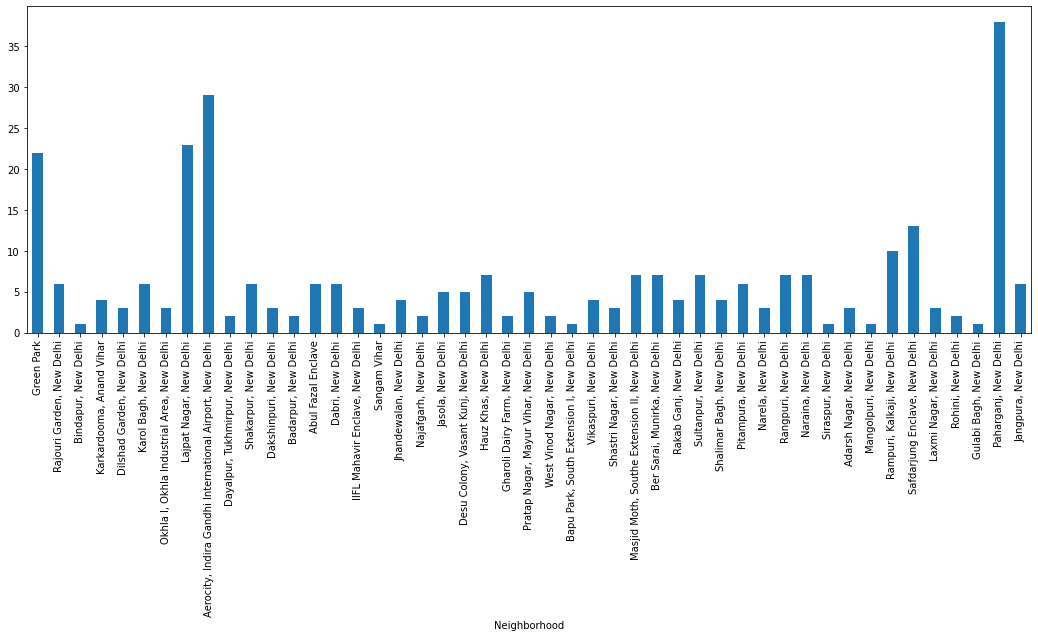

In [214]:
df = delhi_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))


As we can see from the above bar chart, there are many neighborhoods with less than 5 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 5 or more than 5 venues were obtained.

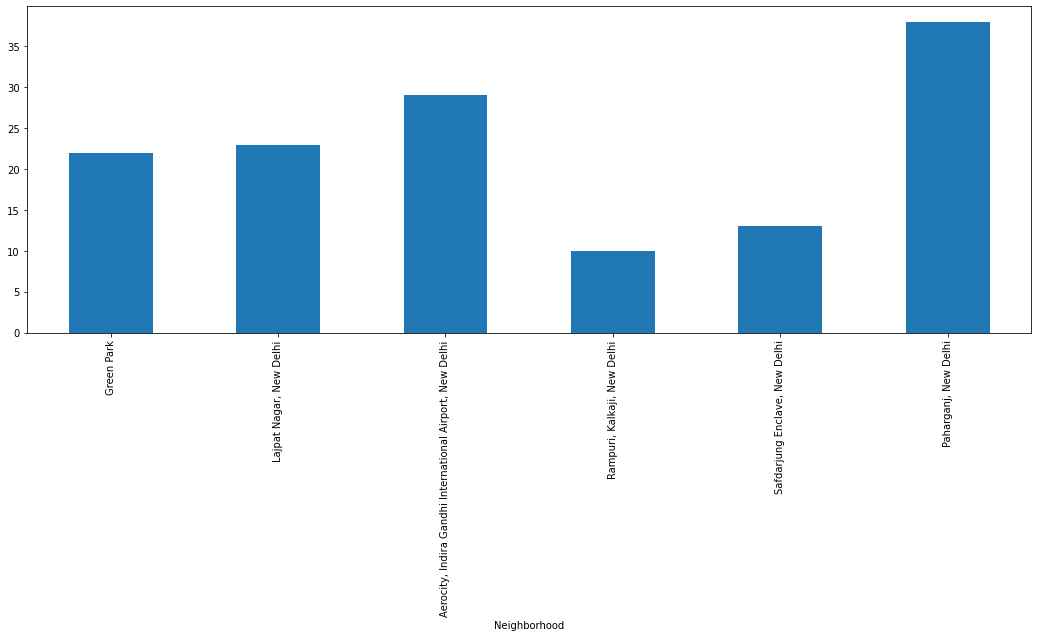

In [224]:
df = df[df > 3]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, delhi_venues_top that contains only the neighborhoods with 4+ venues and the venues with their details included.

In [226]:
delhi_venues_top = delhi_venues[delhi_venues['Neighborhood'].isin(df.index.tolist())]
print (delhi_venues_top.shape)
delhi_venues_top.head()

(135, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Green Park,28.558899,77.202805,Adyar Ananda Bhavan,28.557293,77.202502,Indian Restaurant
1,Green Park,28.558899,77.202805,Gung The Palace,28.556827,77.205298,Korean Restaurant
2,Green Park,28.558899,77.202805,Green Park Market,28.557181,77.202821,Market
3,Green Park,28.558899,77.202805,Tamura,28.558154,77.206356,Japanese Restaurant
4,Green Park,28.558899,77.202805,Evergreen Sweets,28.556497,77.202411,Indian Restaurant


One hot encoding

In [227]:
delhi_onehot = pd.get_dummies(delhi_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = delhi_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = delhi_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
delhi_onehot = delhi_onehot.reindex(columns = fixed_columns)

print(delhi_onehot.shape)
delhi_onehot.head()

(135, 48)


,Neighborhood,Afghan Restaurant,Arcade,Asian Restaurant,Bakery,Bar,Bed & Breakfast,Buffet,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,Department Store,Dessert Shop,Donut Shop,Fast Food Restaurant,Food Truck,French Restaurant,Gym,Gym / Fitness Center,Hostel,Hotel,Hotel Bar,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lounge,Market,Motel,Movie Theater,Nightclub,Park,Pizza Place,Platform,Punjabi Restaurant,Restaurant,Road,Sandwich Place,Shopping Mall,Spa,Sporting Goods Shop,Stadium,Tibetan Restaurant,Train Station
0,Green Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Green Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Green Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Green Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Green Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [232]:
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
print(delhi_grouped.shape)
delhi_grouped.head()

(6, 48)


,Neighborhood,Afghan Restaurant,Arcade,Asian Restaurant,Bakery,Bar,Bed & Breakfast,Buffet,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,Department Store,Dessert Shop,Donut Shop,Fast Food Restaurant,Food Truck,French Restaurant,Gym,Gym / Fitness Center,Hostel,Hotel,Hotel Bar,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Lounge,Market,Motel,Movie Theater,Nightclub,Park,Pizza Place,Platform,Punjabi Restaurant,Restaurant,Road,Sandwich Place,Shopping Mall,Spa,Sporting Goods Shop,Stadium,Tibetan Restaurant,Train Station
0,"Aerocity, Indira Gandhi International Airport,...",0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.068966,0.000000,0.034483,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.344828,0.068966,0.000000,0.103448,0.000000,0.034483,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.034483,0.034483,0.000000,0.0,0.034483,0.034483,0.000000,0.0,0.000000,0.034483
1,Green Park,0.000000,0.000000,0.045455,0.000000,0.045455,0.000000,0.000000,0.045455,0.045455,0.000000,0.181818,0.000000,0.000000,0.0,0.090909,0.000000,0.0,0.0,0.0,0.0,0.000000,0.045455,0.000000,0.000000,0.227273,0.000000,0.000000,0.045455,0.045455,0.000000,0.045455,0.000000,0.000000,0.0,0.045455,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,"Lajpat Nagar, New Delhi",0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.043478,0.086957,0.130435,0.000000,0.0,0.086957,0.086957,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.043478,0.043478,0.000000,0.000000,0.000000,0.000000,0.086957,0.000000,0.043478,0.0,0.000000,0.086957,0.000000,0.000000,0.043478,0.000000,0.0,0.000000,0.000000,0.043478,0.0,0.000000,0.000000
3,"Paharganj, New Delhi",0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.078947,0.026316,0.000000,0.026316,0.000000,0.000000,0.0,0.000000,0.052632,0.0,0.0,0.0,0.0,0.026316,0.342105,0.000000,0.026316,0.052632,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.026316,0.000000,0.0,0.000000,0.026316,0.105263,0.000000,0.052632,0.026316,0.0,0.000000,0.000000,0.000000,0.0,0.026316,0.026316
4,"Rampuri, Kalkaji, New Delhi",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.1,0.000000,0.100000,0.1,0.0,0.2,0.0,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


The following function returns the top_venues of each neighborhood.

In [233]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe neighborhoods_venues_sorted.

In [234]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aerocity, Indira Gandhi International Airport,...",Hotel,Indian Restaurant,Coffee Shop,Hotel Bar,Train Station,Bed & Breakfast,Lounge,Italian Restaurant,Buffet,Punjabi Restaurant
1,Green Park,Indian Restaurant,Coffee Shop,Donut Shop,Pizza Place,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Park,Café,Bar
2,"Lajpat Nagar, New Delhi",Convenience Store,Pizza Place,Fast Food Restaurant,Donut Shop,Market,Coffee Shop,Café,Afghan Restaurant,Indian Restaurant,Indie Movie Theater
3,"Paharganj, New Delhi",Hotel,Platform,Café,Fast Food Restaurant,Restaurant,Indian Restaurant,Korean Restaurant,Train Station,Motel,Bakery
4,"Rampuri, Kalkaji, New Delhi",Gym,Hotel,Clothing Store,Food Truck,Sandwich Place,Fast Food Restaurant,Dessert Shop,Pizza Place,Convenience Store,Gym / Fitness Center


### Cluster Neighborhoods
Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette_score to obtain the best value for the number of clusters.

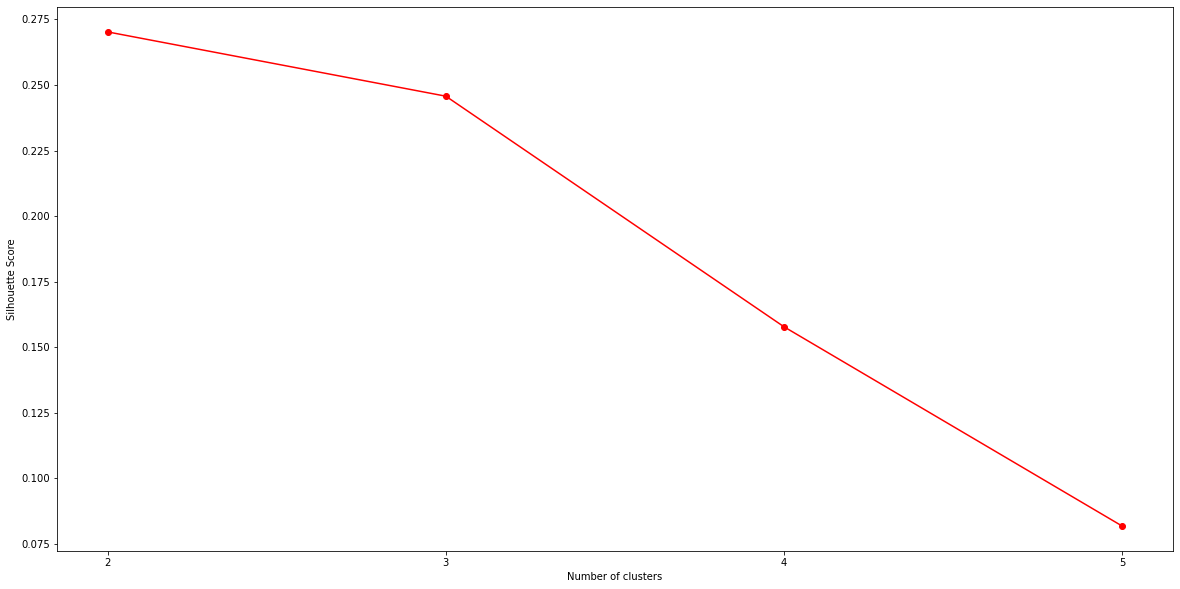

In [242]:
delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)

max_score = 6
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(delhi_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(delhi_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 2. So, lets consider the number of clusters as 2.

In [246]:
# select best number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 0, 0, 0], dtype=int32)

Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe delhi_merged which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [251]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = delhi_venues_top[delhi_venues_top.columns[0:3]].drop_duplicates()
delhi_merged.reset_index(drop = True, inplace = True)

delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

print (delhi_merged.shape)
delhi_merged.head()

(6, 14)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Green Park,28.558899,77.202805,1,Indian Restaurant,Coffee Shop,Donut Shop,Pizza Place,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Park,Café,Bar
1,"Lajpat Nagar, New Delhi",28.569271,77.244110,1,Convenience Store,Pizza Place,Fast Food Restaurant,Donut Shop,Market,Coffee Shop,Café,Afghan Restaurant,Indian Restaurant,Indie Movie Theater
2,"Aerocity, Indira Gandhi International Airport,...",28.550421,77.121765,0,Hotel,Indian Restaurant,Coffee Shop,Hotel Bar,Train Station,Bed & Breakfast,Lounge,Italian Restaurant,Buffet,Punjabi Restaurant
3,"Rampuri, Kalkaji, New Delhi",28.536673,77.259552,0,Gym,Hotel,Clothing Store,Food Truck,Sandwich Place,Fast Food Restaurant,Dessert Shop,Pizza Place,Convenience Store,Gym / Fitness Center
4,"Safdarjung Enclave, New Delhi",28.563286,77.191154,0,Hotel,Spa,Park,Gym / Fitness Center,French Restaurant,Fast Food Restaurant,Coffee Shop,Nightclub,Stadium,Bed & Breakfast


## Results
Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

### Cluster 1

In [334]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Aerocity, Indira Gandhi International Airport,...",Hotel,Indian Restaurant,Coffee Shop,Hotel Bar,Train Station,Bed & Breakfast,Lounge,Italian Restaurant,Buffet,Punjabi Restaurant
3,"Rampuri, Kalkaji, New Delhi",Gym,Hotel,Clothing Store,Food Truck,Sandwich Place,Fast Food Restaurant,Dessert Shop,Pizza Place,Convenience Store,Gym / Fitness Center
4,"Safdarjung Enclave, New Delhi",Hotel,Spa,Park,Gym / Fitness Center,French Restaurant,Fast Food Restaurant,Coffee Shop,Nightclub,Stadium,Bed & Breakfast
5,"Paharganj, New Delhi",Hotel,Platform,Café,Fast Food Restaurant,Restaurant,Indian Restaurant,Korean Restaurant,Train Station,Motel,Bakery


In [335]:
cluster1 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Hotel                   4
Fast Food Restaurant    3
Indian Restaurant       2
Gym / Fitness Center    2
Bed & Breakfast         2
Train Station           2
Coffee Shop             2
Gym                     1
French Restaurant       1
Pizza Place             1
dtype: int64


### Cluster 2

In [336]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Green Park,Indian Restaurant,Coffee Shop,Donut Shop,Pizza Place,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Park,Café,Bar
1,"Lajpat Nagar, New Delhi",Convenience Store,Pizza Place,Fast Food Restaurant,Donut Shop,Market,Coffee Shop,Café,Afghan Restaurant,Indian Restaurant,Indie Movie Theater


In [337]:
cluster2 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Pizza Place             2
Indian Restaurant       2
Donut Shop              2
Coffee Shop             2
Café                    2
Park                    1
Market                  1
Afghan Restaurant       1
Fast Food Restaurant    1
Convenience Store       1
dtype: int64


### Cluster 3

In [339]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Aerocity, Indira Gandhi International Airport,...",Hotel,Indian Restaurant,Coffee Shop,Hotel Bar,Train Station,Bed & Breakfast,Lounge,Italian Restaurant,Buffet,Punjabi Restaurant
3,"Rampuri, Kalkaji, New Delhi",Gym,Hotel,Clothing Store,Food Truck,Sandwich Place,Fast Food Restaurant,Dessert Shop,Pizza Place,Convenience Store,Gym / Fitness Center
4,"Safdarjung Enclave, New Delhi",Hotel,Spa,Park,Gym / Fitness Center,French Restaurant,Fast Food Restaurant,Coffee Shop,Nightclub,Stadium,Bed & Breakfast
5,"Paharganj, New Delhi",Hotel,Platform,Café,Fast Food Restaurant,Restaurant,Indian Restaurant,Korean Restaurant,Train Station,Motel,Bakery


In [340]:
cluster3 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Hotel                   4
Fast Food Restaurant    3
Indian Restaurant       2
Gym / Fitness Center    2
Bed & Breakfast         2
Train Station           2
Coffee Shop             2
Gym                     1
French Restaurant       1
Pizza Place             1
dtype: int64


### Cluster 4

In [341]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Green Park,Indian Restaurant,Coffee Shop,Donut Shop,Pizza Place,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Park,Café,Bar
1,"Lajpat Nagar, New Delhi",Convenience Store,Pizza Place,Fast Food Restaurant,Donut Shop,Market,Coffee Shop,Café,Afghan Restaurant,Indian Restaurant,Indie Movie Theater


In [342]:
cluster4 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Pizza Place             2
Indian Restaurant       2
Donut Shop              2
Coffee Shop             2
Café                    2
Park                    1
Market                  1
Afghan Restaurant       1
Fast Food Restaurant    1
Convenience Store       1
dtype: int64


### Cluster 5

In [344]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Aerocity, Indira Gandhi International Airport,...",Hotel,Indian Restaurant,Coffee Shop,Hotel Bar,Train Station,Bed & Breakfast,Lounge,Italian Restaurant,Buffet,Punjabi Restaurant
3,"Rampuri, Kalkaji, New Delhi",Gym,Hotel,Clothing Store,Food Truck,Sandwich Place,Fast Food Restaurant,Dessert Shop,Pizza Place,Convenience Store,Gym / Fitness Center
4,"Safdarjung Enclave, New Delhi",Hotel,Spa,Park,Gym / Fitness Center,French Restaurant,Fast Food Restaurant,Coffee Shop,Nightclub,Stadium,Bed & Breakfast
5,"Paharganj, New Delhi",Hotel,Platform,Café,Fast Food Restaurant,Restaurant,Indian Restaurant,Korean Restaurant,Train Station,Motel,Bakery


In [345]:
cluster5 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Hotel                   4
Fast Food Restaurant    3
Indian Restaurant       2
Gym / Fitness Center    2
Bed & Breakfast         2
Train Station           2
Coffee Shop             2
Gym                     1
French Restaurant       1
Pizza Place             1
dtype: int64


### Cluster 6

In [346]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Green Park,Indian Restaurant,Coffee Shop,Donut Shop,Pizza Place,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Park,Café,Bar
1,"Lajpat Nagar, New Delhi",Convenience Store,Pizza Place,Fast Food Restaurant,Donut Shop,Market,Coffee Shop,Café,Afghan Restaurant,Indian Restaurant,Indie Movie Theater


In [347]:
cluster6 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Hotel                   4
Fast Food Restaurant    3
Indian Restaurant       2
Gym / Fitness Center    2
Bed & Breakfast         2
Train Station           2
Coffee Shop             2
Gym                     1
French Restaurant       1
Pizza Place             1
dtype: int64


### Cluster 7

In [348]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Aerocity, Indira Gandhi International Airport,...",Hotel,Indian Restaurant,Coffee Shop,Hotel Bar,Train Station,Bed & Breakfast,Lounge,Italian Restaurant,Buffet,Punjabi Restaurant
3,"Rampuri, Kalkaji, New Delhi",Gym,Hotel,Clothing Store,Food Truck,Sandwich Place,Fast Food Restaurant,Dessert Shop,Pizza Place,Convenience Store,Gym / Fitness Center
4,"Safdarjung Enclave, New Delhi",Hotel,Spa,Park,Gym / Fitness Center,French Restaurant,Fast Food Restaurant,Coffee Shop,Nightclub,Stadium,Bed & Breakfast
5,"Paharganj, New Delhi",Hotel,Platform,Café,Fast Food Restaurant,Restaurant,Indian Restaurant,Korean Restaurant,Train Station,Motel,Bakery


In [349]:
cluster7 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 0, delhi_merged.columns[[0] +  list(range(4, delhi_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Hotel                   4
Fast Food Restaurant    3
Indian Restaurant       2
Gym / Fitness Center    2
Bed & Breakfast         2
Train Station           2
Coffee Shop             2
Gym                     1
French Restaurant       1
Pizza Place             1
dtype: int64


### Cluster 8

In [350]:
delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Green Park,Indian Restaurant,Coffee Shop,Donut Shop,Pizza Place,Chinese Restaurant,Korean Restaurant,Japanese Restaurant,Park,Café,Bar
1,"Lajpat Nagar, New Delhi",Convenience Store,Pizza Place,Fast Food Restaurant,Donut Shop,Market,Coffee Shop,Café,Afghan Restaurant,Indian Restaurant,Indie Movie Theater


In [351]:
cluster8 = delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[0] + list(range(4, delhi_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Pizza Place             2
Indian Restaurant       2
Donut Shop              2
Coffee Shop             2
Café                    2
Park                    1
Market                  1
Afghan Restaurant       1
Fast Food Restaurant    1
Convenience Store       1
dtype: int64


### Discussion
Lets visulaize the top 5 most common venue categories in each of the cluster.

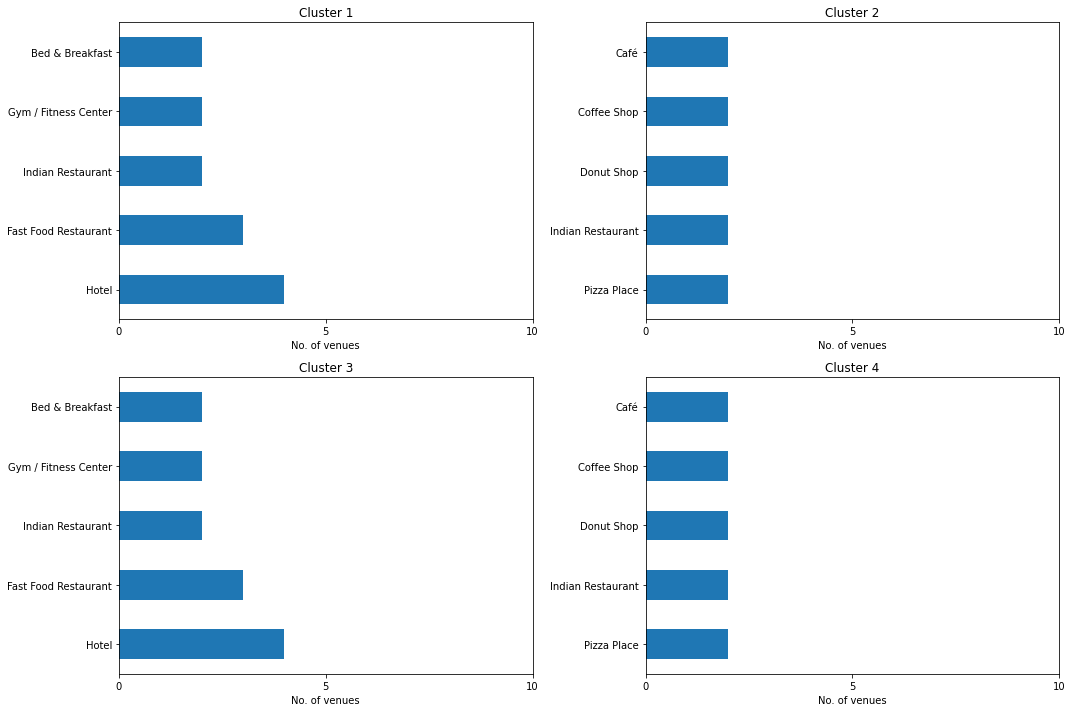

In [355]:
#df_list = [venues1 ,venues2, venues3, venues4]
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
#df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(2, 2)

count = 0
for r in range(2):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

1. Hotel

The neighborhoods in cluster 2 has the highest number of hotels, hence opening one here is not the best choice. So, is it best to open one at the neighborhoods in cluster 1 or 3? Not likely, since the place has a smaller number of food restaurants. Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 4.

2. Cafe

The neighborhoods 4 has notable number of cafe. By using the same procedure as above, the suitable cluster would be the Cluster 1 and Cluster 3, since it has not much cafe and also it has many Hotels and Restaurants which gives an advantage.

Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.

Map of Delhi with the clusters superimposed on top.

This map can be used to find a suitable location to start a new business based on the category.

In [356]:
# create map
delhi_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Neighborhood Latitude'], delhi_merged['Neighborhood Longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(delhi_clusters_map)
       
delhi_clusters_map

This map can also be used to select a vast suggestion area for a particular type of business based on the category.

### Conclusion 
Purpose of this project was to analyze the neighborhoods of Delhi and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

### Thank you